In [2]:
# Import libraries
import numpy as np
import pandas as pd
import yaml
import torch
import json
import random
from pathlib import Path
from sentence_transformers import SentenceTransformer
from transformers import CLIPProcessor, CLIPModel
from PIL import Image, ImageFilter, ImageEnhance
import requests
from io import BytesIO
import chromadb
import optuna
from optuna.visualization import plot_optimization_history, plot_param_importances
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
import warnings

warnings.filterwarnings('ignore')

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

print("✅ Libraries imported")

✅ Libraries imported


In [3]:
# Setup paths and load config
import os
os.environ["ANONYMIZED_TELEMETRY"] = "False"

ROOT = Path("..").resolve()
CONFIG_PATH = ROOT / "configs" / "config.yaml"

with open(CONFIG_PATH, "r", encoding="utf-8") as f:
    config = yaml.safe_load(f)

VDB_DIR = ROOT / "outputs" / "vector_db"
DATA_PROCESSED = ROOT / config.get("data", {}).get("processed_path", "Data/processed/")
OUTPUTS_DIR = ROOT / "outputs"

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

print(f"📁 Root: {ROOT}")
print(f"🖥️  Device: {DEVICE}")

📁 Root: /home/roshan/Aria/mlops
🖥️  Device: cuda


In [4]:
# Load models and ChromaDB
TEXT_MODEL_NAME = config.get("feature_engineering", {}).get("text", {}).get("model_name", "paraphrase-multilingual-MiniLM-L12-v2")
IMAGE_MODEL_NAME = config.get("feature_engineering", {}).get("image", {}).get("model_name", "openai/clip-vit-base-patch32")

print("⏳ Loading models...")
text_model = SentenceTransformer(TEXT_MODEL_NAME, device=DEVICE)
clip_model = CLIPModel.from_pretrained(IMAGE_MODEL_NAME).to(DEVICE)
clip_processor = CLIPProcessor.from_pretrained(IMAGE_MODEL_NAME)
clip_model.eval()

print("⏳ Connecting to ChromaDB...")
chroma_client = chromadb.PersistentClient(path=str(VDB_DIR))
col_text = chroma_client.get_collection("products_text")
col_image = chroma_client.get_collection("products_image")

print(f"✅ Text collection: {col_text.count()} embeddings")
print(f"✅ Image collection: {col_image.count()} embeddings")

⏳ Loading models...


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.
Fetching 1 files: 100%|██████████| 1/1 [00:00<00:00, 12192.74it/s]


⏳ Connecting to ChromaDB...
✅ Text collection: 1022296 embeddings
✅ Image collection: 9982 embeddings


In [20]:
# Noise generation functions

def add_text_noise(text: str, noise_level: float = 0.05) -> str:
    """Add character-level noise to Persian text."""
    if not text or len(text) < 3:
        return text
    
    chars = list(text)
    n_changes = max(1, int(len(chars) * noise_level))
    
    for _ in range(n_changes):
        pos = random.randint(0, len(chars) - 1)
        operation = random.choice(['swap', 'delete', 'duplicate'])
        
        if operation == 'swap' and pos < len(chars) - 1:
            chars[pos], chars[pos + 1] = chars[pos + 1], chars[pos]
        elif operation == 'delete' and len(chars) > 3:
            chars.pop(pos)
        elif operation == 'duplicate':
            chars.insert(pos, chars[pos])
    
    return ''.join(chars)


def add_image_noise(image: Image.Image) -> Image.Image:
    """Add visual noise to image (blur, brightness, rotation)."""
    # Random blur
    if random.random() > 0.5:
        image = image.filter(ImageFilter.GaussianBlur(radius=random.uniform(0.5, 2.0)))
    
    # Random brightness/contrast
    if random.random() > 0.5:
        enhancer = ImageEnhance.Brightness(image)
        image = enhancer.enhance(random.uniform(0.7, 1.3))
    
    # Random rotation
    if random.random() > 0.5:
        angle = random.uniform(-15, 15)
        image = image.rotate(angle, fillcolor='white', expand=False)
    
    return image


print("✅ Noise functions defined")

✅ Noise functions defined


In [21]:
# Create test dataset
TEST_SIZE = 100  # Number of test queries

print(f"⏳ Creating test dataset with {TEST_SIZE} samples...")

# Get all products that have both text and image embeddings
image_ids = set(col_image.get(include=[])["ids"])
text_data = col_text.get(include=["documents", "metadatas"], limit=col_text.count())

# Filter products that have both modalities
available_products = []
for i, pid in enumerate(text_data["ids"]):
    if pid in image_ids:
        available_products.append({
            "product_id": pid,
            "text": text_data["documents"][i],
            "metadata": text_data["metadatas"][i]
        })

print(f"✅ Found {len(available_products)} products with both text and image")

# Sample test set (stratified by category if possible)
if len(available_products) > TEST_SIZE:
    test_products = random.sample(available_products, TEST_SIZE)
else:
    test_products = available_products

print(f"✅ Sampled {len(test_products)} test products")

⏳ Creating test dataset with 100 samples...
✅ Found 9982 products with both text and image
✅ Sampled 100 test products


In [26]:
# Generate noisy queries
print("⏳ Generating noisy queries...")

test_dataset = []

for item in test_products:
    # Get image
    try:
        img_data = col_image.get(ids=[item["product_id"]], include=["metadatas"])
        if not img_data["ids"]:
            continue
        
        img_url = img_data["metadatas"][0].get("image_url")
        response = requests.get(img_url, timeout=10)
        original_image = Image.open(BytesIO(response.content)).convert("RGB")
        
        # Extract only product name (before " | دسته:" or similar separators)
        original_text = item["text"]
        if " | " in original_text:
            product_name_only = original_text
        else:
            product_name_only = original_text.strip()
        
        # Create noisy version of product name only
        noisy_text = add_text_noise(product_name_only)
        noisy_image = add_image_noise(original_image.copy())
        
        test_dataset.append({
            "query_id": f"test_{len(test_dataset):03d}",
            "product_id": item["product_id"],
            "original_text": product_name_only,  # Store only product name
            "noisy_text": noisy_text,
            "original_image": original_image,
            "noisy_image": noisy_image,
            "relevant_ids": [item["product_id"]],  # Ground truth
            "metadata": item["metadata"]
        })
        
        if len(test_dataset) % 20 == 0:
            print(f"   Progress: {len(test_dataset)} queries generated")
    
    except Exception as e:
        continue

print(f"\n✅ Test dataset created: {len(test_dataset)} queries")
print(f"\n📋 Sample query:")
print(f"   Original text: {test_dataset[0]['original_text'][:80]}")
print(f"   Noisy text: {test_dataset[0]['noisy_text'][:80]}")
print(f"   Ground truth: {test_dataset[0]['product_id']}")

⏳ Generating noisy queries...


   Progress: 20 queries generated
   Progress: 40 queries generated
   Progress: 60 queries generated
   Progress: 80 queries generated
   Progress: 100 queries generated

✅ Test dataset created: 100 queries

📋 Sample query:
   Original text: روفرشی 12 متری مخمل زرکدار طرح باغ بهشت رنگ طوسی تیره | دسته: روفرشی
   Noisy text: ورفرشی 12 متری مخخمل زرکدار طرح باغ بهشت رنگ طوسی تیره | دسته:ر وفرشی
   Ground truth: ocglgw


In [8]:
# Retrieval functions

def text_retrieval(query: str, k: int = 10) -> List[str]:
    """Retrieve product IDs using text query."""
    query_embedding = text_model.encode([query], normalize_embeddings=True)
    results = col_text.query(
        query_embeddings=query_embedding.tolist(),
        n_results=k,
        include=[]
    )
    return results["ids"][0]


def image_retrieval(image: Image.Image, k: int = 10) -> List[str]:
    """Retrieve product IDs using image query."""
    inputs = clip_processor(images=image, return_tensors="pt").to(DEVICE)
    with torch.no_grad():
        image_features = clip_model.get_image_features(**inputs)
    
    image_embedding = image_features / image_features.norm(dim=-1, keepdim=True)
    image_embedding = image_embedding.cpu().numpy().flatten()
    
    results = col_image.query(
        query_embeddings=[image_embedding.tolist()],
        n_results=k,
        include=[]
    )
    return results["ids"][0]


def multimodal_retrieval(text_query: str, image: Image.Image, k: int = 10, alpha: float = 0.5) -> List[str]:
    """Retrieve product IDs using both text and image with weighted fusion."""
    # Get separate results
    text_results = text_retrieval(text_query, k=k*2)
    image_results = image_retrieval(image, k=k*2)
    
    # Score fusion
    scores = {}
    for rank, pid in enumerate(text_results):
        scores[pid] = alpha * (1.0 / (rank + 1))
    
    for rank, pid in enumerate(image_results):
        if pid in scores:
            scores[pid] += (1 - alpha) * (1.0 / (rank + 1))
        else:
            scores[pid] = (1 - alpha) * (1.0 / (rank + 1))
    
    # Sort and return top-k
    ranked = sorted(scores.items(), key=lambda x: x[1], reverse=True)
    return [pid for pid, _ in ranked[:k]]


print("✅ Retrieval functions ready")

✅ Retrieval functions ready


In [28]:
# Evaluation metrics

def mean_reciprocal_rank(retrieved_ids: List[str], relevant_ids: List[str]) -> float:
    """
    Calculate MRR (Mean Reciprocal Rank).
    Returns 1/rank of first relevant item, 0 if none found.
    """
    for rank, pid in enumerate(retrieved_ids, 1):
        if pid in relevant_ids:
            return 1.0 / rank
    return 0.0


def precision_at_k(retrieved_ids: List[str], relevant_ids: List[str], k: int = 10) -> float:
    """
    Calculate Precision@k.
    Returns fraction of relevant items in top-k.
    """
    retrieved_k = retrieved_ids[:k]
    relevant_count = sum(1 for pid in retrieved_k if pid in relevant_ids)
    return relevant_count / k if k > 0 else 0.0


def category_hit_rate(retrieved_ids: List[str], query_category: str, start_rank: int = 2, end_rank: int = 10) -> float:
    """
    Calculate category hit rate - whether any retrieved product (excluding rank 1) 
    belongs to the same category as the query.
    
    Args:
        retrieved_ids: List of retrieved product IDs
        query_category: Category of the query product
        start_rank: Start checking from this rank (default 2, to skip exact match)
        end_rank: End checking at this rank (default 10)
    
    Returns:
        1.0 if at least one product in range matches category, 0.0 otherwise
    """
    if not query_category or query_category == "N/A":
        return 0.0
    
    # Check products from start_rank to end_rank (1-indexed, so adjust)
    products_to_check = retrieved_ids[start_rank-1:end_rank]
    
    for pid in products_to_check:
        try:
            # Fetch category from ChromaDB
            result = col_text.get(ids=[pid], include=["metadatas"])
            if result["ids"]:
                retrieved_category = result["metadatas"][0].get("category_title", "")
                if retrieved_category == query_category:
                    return 1.0
        except:
            continue
    
    return 0.0


def evaluate_retrieval(test_data: List[Dict], retrieval_fn, k: int = 10, compute_category_hit: bool = False) -> Dict:
    """
    Evaluate retrieval function on test dataset.
    Returns average MRR, Precision@k, and optionally category hit rate.
    """
    mrr_scores = []
    precision_scores = []
    category_hits = []
    
    for item in test_data:
        retrieved = retrieval_fn(item, k=k)
        
        mrr = mean_reciprocal_rank(retrieved, item["relevant_ids"])
        precision = precision_at_k(retrieved, item["relevant_ids"], k=k)
        
        mrr_scores.append(mrr)
        precision_scores.append(precision)
        
        # Compute category hit rate for image retrieval
        if compute_category_hit:
            query_category = item["metadata"].get("category_title", "")
            cat_hit = category_hit_rate(retrieved, query_category, start_rank=2, end_rank=10)
            category_hits.append(cat_hit)
    
    results = {
        "MRR": np.mean(mrr_scores),
        "Precision@k": np.mean(precision_scores),
        "num_queries": len(test_data)
    }
    
    if compute_category_hit:
        results["Category_Hit_Rate@2-10"] = np.mean(category_hits)
    
    return results


print("✅ Metrics defined")

✅ Metrics defined


In [12]:
# Define Optuna objective function

K_VALUE = 10  # Fixed k for retrieval

def objective(trial):
    """Optuna objective: maximize MRR for multimodal retrieval."""
    # Suggest alpha value
    alpha = trial.suggest_float("alpha", 0.0, 1.0)
    
    # Define retrieval function with this alpha
    def retrieval_fn(item, k=K_VALUE):
        return multimodal_retrieval(
            text_query=item["noisy_text"],
            image=item["noisy_image"],
            k=k,
            alpha=alpha
        )
    
    # Evaluate on test dataset
    results = evaluate_retrieval(test_dataset, retrieval_fn, k=K_VALUE)
    
    # Objective: maximize MRR (primary) + Precision (secondary)
    score = results["MRR"] + 0.1 * results["Precision@k"]
    
    return score


print("✅ Objective function defined")
print(f"📊 Search space: alpha ∈ [0.0, 1.0]")
print(f"🎯 Objective: Maximize (MRR + 0.1 × Precision@{K_VALUE})")

✅ Objective function defined
📊 Search space: alpha ∈ [0.0, 1.0]
🎯 Objective: Maximize (MRR + 0.1 × Precision@10)


In [13]:
# Run Optuna optimization
N_TRIALS = 20  # Number of optimization trials

print(f"⏳ Starting Optuna optimization ({N_TRIALS} trials)...")
print("=" * 70)

# Create study
study = optuna.create_study(
    direction="maximize",
    study_name="multimodal_alpha_tuning",
    sampler=optuna.samplers.TPESampler(seed=RANDOM_SEED)
)

# Optimize
study.optimize(objective, n_trials=N_TRIALS, show_progress_bar=True)

print("\n" + "=" * 70)
print("✅ Optimization complete!")
print("=" * 70)
print(f"\n🏆 Best trial:")
print(f"   Trial number: {study.best_trial.number}")
print(f"   Best score: {study.best_trial.value:.4f}")
print(f"   Best alpha: {study.best_params['alpha']:.4f}")

[I 2026-01-04 19:07:07,944] A new study created in memory with name: multimodal_alpha_tuning


⏳ Starting Optuna optimization (20 trials)...


Best trial: 0. Best value: 1.01:   5%|▌         | 1/20 [00:05<01:43,  5.43s/it]

[I 2026-01-04 19:07:13,377] Trial 0 finished with value: 1.01 and parameters: {'alpha': 0.3745401188473625}. Best is trial 0 with value: 1.01.


Best trial: 0. Best value: 1.01:  10%|█         | 2/20 [00:10<01:29,  4.95s/it]

[I 2026-01-04 19:07:17,992] Trial 1 finished with value: 0.6810071428571428 and parameters: {'alpha': 0.9507143064099162}. Best is trial 0 with value: 1.01.


Best trial: 0. Best value: 1.01:  15%|█▌        | 3/20 [00:14<01:22,  4.84s/it]

[I 2026-01-04 19:07:22,707] Trial 2 finished with value: 0.7683333333333333 and parameters: {'alpha': 0.7319939418114051}. Best is trial 0 with value: 1.01.


Best trial: 0. Best value: 1.01:  20%|██        | 4/20 [00:19<01:16,  4.76s/it]

[I 2026-01-04 19:07:27,345] Trial 3 finished with value: 0.87 and parameters: {'alpha': 0.5986584841970366}. Best is trial 0 with value: 1.01.


Best trial: 0. Best value: 1.01:  25%|██▌       | 5/20 [00:24<01:10,  4.70s/it]

[I 2026-01-04 19:07:31,943] Trial 4 finished with value: 1.01 and parameters: {'alpha': 0.15601864044243652}. Best is trial 0 with value: 1.01.


Best trial: 0. Best value: 1.01:  30%|███       | 6/20 [00:28<01:04,  4.64s/it]

[I 2026-01-04 19:07:36,465] Trial 5 finished with value: 1.01 and parameters: {'alpha': 0.15599452033620265}. Best is trial 0 with value: 1.01.


Best trial: 0. Best value: 1.01:  35%|███▌      | 7/20 [00:33<01:00,  4.63s/it]

[I 2026-01-04 19:07:41,082] Trial 6 finished with value: 1.01 and parameters: {'alpha': 0.05808361216819946}. Best is trial 0 with value: 1.01.


Best trial: 0. Best value: 1.01:  40%|████      | 8/20 [00:37<00:55,  4.59s/it]

[I 2026-01-04 19:07:45,565] Trial 7 finished with value: 0.7160238095238095 and parameters: {'alpha': 0.8661761457749352}. Best is trial 0 with value: 1.01.


Best trial: 0. Best value: 1.01:  45%|████▌     | 9/20 [00:42<00:50,  4.58s/it]

[I 2026-01-04 19:07:50,130] Trial 8 finished with value: 0.855 and parameters: {'alpha': 0.6011150117432088}. Best is trial 0 with value: 1.01.


Best trial: 0. Best value: 1.01:  50%|█████     | 10/20 [00:46<00:45,  4.57s/it]

[I 2026-01-04 19:07:54,678] Trial 9 finished with value: 0.7749999999999999 and parameters: {'alpha': 0.7080725777960455}. Best is trial 0 with value: 1.01.


Best trial: 0. Best value: 1.01:  55%|█████▌    | 11/20 [00:51<00:40,  4.54s/it]

[I 2026-01-04 19:07:59,149] Trial 10 finished with value: 1.01 and parameters: {'alpha': 0.3744766300697283}. Best is trial 0 with value: 1.01.


Best trial: 0. Best value: 1.01:  60%|██████    | 12/20 [00:55<00:36,  4.53s/it]

[I 2026-01-04 19:08:03,643] Trial 11 finished with value: 1.01 and parameters: {'alpha': 0.3121338607313171}. Best is trial 0 with value: 1.01.


Best trial: 0. Best value: 1.01:  65%|██████▌   | 13/20 [01:00<00:31,  4.53s/it]

[I 2026-01-04 19:08:08,177] Trial 12 finished with value: 1.01 and parameters: {'alpha': 0.2861032030153099}. Best is trial 0 with value: 1.01.


Best trial: 0. Best value: 1.01:  70%|███████   | 14/20 [01:04<00:27,  4.53s/it]

[I 2026-01-04 19:08:12,704] Trial 13 finished with value: 1.01 and parameters: {'alpha': 0.009158459720389617}. Best is trial 0 with value: 1.01.


Best trial: 0. Best value: 1.01:  75%|███████▌  | 15/20 [01:09<00:22,  4.51s/it]

[I 2026-01-04 19:08:17,168] Trial 14 finished with value: 1.01 and parameters: {'alpha': 0.4389820243053727}. Best is trial 0 with value: 1.01.


Best trial: 0. Best value: 1.01:  80%|████████  | 16/20 [01:13<00:17,  4.50s/it]

[I 2026-01-04 19:08:21,637] Trial 15 finished with value: 1.01 and parameters: {'alpha': 0.18221085101377776}. Best is trial 0 with value: 1.01.


Best trial: 0. Best value: 1.01:  85%|████████▌ | 17/20 [01:18<00:13,  4.50s/it]

[I 2026-01-04 19:08:26,143] Trial 16 finished with value: 1.01 and parameters: {'alpha': 0.17468902816077297}. Best is trial 0 with value: 1.01.


Best trial: 0. Best value: 1.01:  90%|█████████ | 18/20 [01:22<00:08,  4.49s/it]

[I 2026-01-04 19:08:30,627] Trial 17 finished with value: 1.01 and parameters: {'alpha': 0.4908646181512612}. Best is trial 0 with value: 1.01.


Best trial: 0. Best value: 1.01:  95%|█████████▌| 19/20 [01:27<00:04,  4.48s/it]

[I 2026-01-04 19:08:35,076] Trial 18 finished with value: 1.01 and parameters: {'alpha': 0.2869127750412098}. Best is trial 0 with value: 1.01.


Best trial: 0. Best value: 1.01: 100%|██████████| 20/20 [01:31<00:00,  4.58s/it]

[I 2026-01-04 19:08:39,523] Trial 19 finished with value: 1.01 and parameters: {'alpha': 0.1255529720465406}. Best is trial 0 with value: 1.01.

✅ Optimization complete!

🏆 Best trial:
   Trial number: 0
   Best score: 1.0100
   Best alpha: 0.3745


In [17]:
# Visualization: Optimization history
fig = plot_optimization_history(study)
fig.update_layout(title="Optimization History: MRR + 0.1×Precision@k over Trials")
fig.show()

print(f"\n📈 Convergence: Best score improved from {study.trials[0].value:.4f} to {study.best_value:.4f}")

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

In [29]:
# Evaluate all three modalities
best_alpha = study.best_params["alpha"]

print("⏳ Evaluating all modalities with optimized parameters...")
print("=" * 70)

# 1. Text-only retrieval
def text_only_fn(item, k=K_VALUE):
    return text_retrieval(item["noisy_text"], k=k)

text_results = evaluate_retrieval(test_dataset, text_only_fn, k=K_VALUE)
print(f"\n📝 Text-Only Retrieval:")
print(f"   MRR: {text_results['MRR']:.4f}")
print(f"   Precision@{K_VALUE}: {text_results['Precision@k']:.4f}")

# 2. Image-only retrieval
def image_only_fn(item, k=K_VALUE):
    return image_retrieval(item["noisy_image"], k=k)

image_results = evaluate_retrieval(test_dataset, image_only_fn, k=K_VALUE, compute_category_hit=True)
print(f"\n🖼️  Image-Only Retrieval:")
print(f"   MRR: {image_results['MRR']:.4f}")
print(f"   Precision@{K_VALUE}: {image_results['Precision@k']:.4f}")
print(f"   Category Hit Rate@2-10: {image_results['Category_Hit_Rate@2-10']:.4f}")
print(f"   → {image_results['Category_Hit_Rate@2-10']*100:.1f}% queries found same-category product in ranks 2-10")

# 3. Multimodal retrieval with best alpha
def multimodal_fn(item, k=K_VALUE):
    return multimodal_retrieval(
        item["noisy_text"],
        item["noisy_image"],
        k=k,
        alpha=best_alpha
    )

multimodal_results = evaluate_retrieval(test_dataset, multimodal_fn, k=K_VALUE)
print(f"\n🔀 Multimodal Retrieval (alpha={best_alpha:.4f}):")
print(f"   MRR: {multimodal_results['MRR']:.4f}")
print(f"   Precision@{K_VALUE}: {multimodal_results['Precision@k']:.4f}")

print("\n" + "=" * 70)

# Show sample failures for text-only retrieval
print("\n\n🔍 Sample Text-Only Retrieval Failures:")
print("=" * 70)

failure_count = 0
for i, item in enumerate(test_dataset):
    if failure_count >= 5:  # Show 5 examples
        break
    
    text_ret = text_retrieval(item["noisy_text"], k=10)
    
    # Check if ground truth is not in top-3
    if item['product_id'] not in text_ret[:3]:
        failure_count += 1
        
        # Get rank
        if item['product_id'] in text_ret:
            rank = text_ret.index(item['product_id']) + 1
            rank_str = f"#{rank}"
        else:
            rank_str = "Not in top-10"
        
        print(f"\n{'─'*70}")
        print(f"Failure #{failure_count}")
        print(f"{'─'*70}")
        print(f"Ground Truth: {item['product_id']}")
        print(f"Category: {item['metadata'].get('category_title', 'N/A')}")
        print(f"Brand: {item['metadata'].get('brand_title', 'N/A')}")
        print(f"\n📝 Original text: {item['original_text'][:100]}...")
        print(f"🔄 Noisy text:    {item['noisy_text'][:100]}...")
        print(f"\n❌ Ground truth ranked: {rank_str}")
        print(f"\n✅ Top-3 retrieved instead:")
        
        # Fetch and show what was retrieved
        for j, ret_id in enumerate(text_ret[:3], 1):
            ret_data = col_text.get(ids=[ret_id], include=["documents", "metadatas"])
            if ret_data["ids"]:
                ret_text = ret_data["documents"][0][:80]
                ret_cat = ret_data["metadatas"][0].get("category_title", "N/A")
                print(f"   {j}. {ret_id} - {ret_cat}")
                print(f"      Text: {ret_text}...")

print("\n" + "=" * 70)

⏳ Evaluating all modalities with optimized parameters...

📝 Text-Only Retrieval:
   MRR: 0.7763
   Precision@10: 0.0870

🖼️  Image-Only Retrieval:
   MRR: 0.9750
   Precision@10: 0.0980
   Category Hit Rate@2-10: 0.6400
   → 64.0% queries found same-category product in ranks 2-10

🔀 Multimodal Retrieval (alpha=0.3745):
   MRR: 0.9870
   Precision@10: 0.1000



🔍 Sample Text-Only Retrieval Failures:

──────────────────────────────────────────────────────────────────────
Failure #1
──────────────────────────────────────────────────────────────────────
Ground Truth: aiwmxn
Category: شمع و جاشمعی
Brand: 

📝 Original text: شمع عدد نه اکلیلی صورتی | دسته: شمع و جاشمعی...
🔄 Noisy text:    شمع عدد نه اکلیلی صورتی | دسته: شمعع و اجشمعی...

❌ Ground truth ranked: Not in top-10

✅ Top-3 retrieved instead:
   1. yjpltn - آینه دکوراتیو
      Text: آینه شمعدان با شعر : عشق یعنی در میان | دسته: آینه دکوراتیو...
   2. tilizc - آینه دکوراتیو
      Text: آینه و شمعدان | دسته: آینه دکوراتیو...
   3. opbi

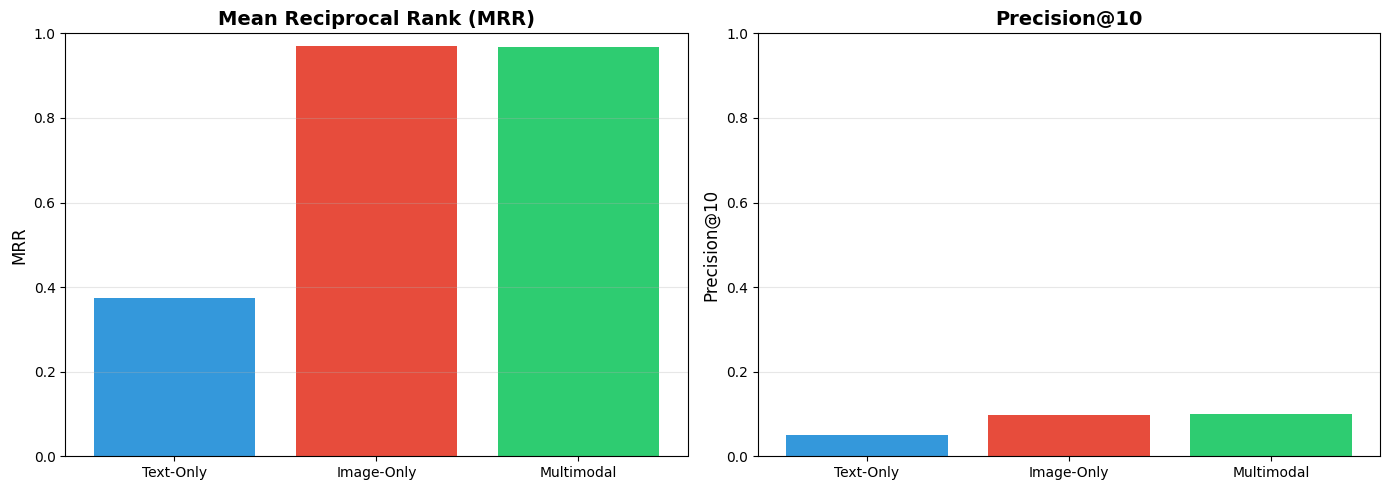


📊 Performance Comparison Table:
  Modality      MRR  Precision@10
 Text-Only 0.374278         0.050
Image-Only 0.970000         0.098
Multimodal 0.968667         0.099


In [24]:
# Comparison visualization
comparison_data = {
    "Modality": ["Text-Only", "Image-Only", "Multimodal"],
    "MRR": [text_results["MRR"], image_results["MRR"], multimodal_results["MRR"]],
    f"Precision@{K_VALUE}": [
        text_results["Precision@k"],
        image_results["Precision@k"],
        multimodal_results["Precision@k"]
    ]
}

df_comparison = pd.DataFrame(comparison_data)

# Bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# MRR comparison
axes[0].bar(df_comparison["Modality"], df_comparison["MRR"], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[0].set_ylabel("MRR", fontsize=12)
axes[0].set_title("Mean Reciprocal Rank (MRR)", fontsize=14, fontweight='bold')
axes[0].set_ylim(0, 1.0)
axes[0].grid(axis='y', alpha=0.3)

# Precision comparison
axes[1].bar(df_comparison["Modality"], df_comparison[f"Precision@{K_VALUE}"], color=['#3498db', '#e74c3c', '#2ecc71'])
axes[1].set_ylabel(f"Precision@{K_VALUE}", fontsize=12)
axes[1].set_title(f"Precision@{K_VALUE}", fontsize=14, fontweight='bold')
axes[1].set_ylim(0, 1.0)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Display table
print("\n📊 Performance Comparison Table:")
print(df_comparison.to_string(index=False))